<a href="https://colab.research.google.com/github/sinux-l5d/PROJ002/blob/main/animal_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Options for this notebook
DO = {
    "UNZIP": False, # unzip ./animal-10.zip to ./animal-10
    "ZIP": False, # zip ./logs and best.keras to model_and_logs.zip
    "TRAIN": False, # train the model (if False, load the existing model from best.keras),
    "SAVE_UNIVERSAL": False, # save the model in .pb format with model.save()
}
do = lambda x: DO.get(x, False) 

In [2]:
from dataclasses import dataclass
from pathlib import Path
from os import listdir
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

2024-02-02 10:29:48.933142: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 10:29:48.933172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 10:29:48.933830: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 10:29:48.938847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
DATADIR = "animal10"
WIDTH = 200
HEIGHT = 200

In [4]:
if do("UNZIP"):
    data_zip = "animal-10.zip"
    with zipfile.ZipFile(data_zip,"r") as zip_ref:
        zip_ref.extractall(DATADIR)

In [5]:
#run on graphic card if possible
gpus = tf.config.list_physical_devices('GPU')
print("nb gpus", len(gpus))
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

nb gpus 1
1 Physical GPUs, 1 Logical GPU


2024-02-02 10:29:50.737441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 10:29:50.763081: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 10:29:50.763320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
translate = {'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo', 'horse': 'cavallo', 'ragno': 'spider', 'sheep': 'pecora'}
CATEGORIES = [translate[name] for name in listdir(DATADIR + "/raw-img")]
CATEGORIES.sort()
print(list(enumerate(CATEGORIES)))

[(0, 'butterfly'), (1, 'cat'), (2, 'chicken'), (3, 'cow'), (4, 'dog'), (5, 'elephant'), (6, 'horse'), (7, 'sheep'), (8, 'spider'), (9, 'squirrel')]


In [7]:
@dataclass
class Collection:
  path = Path(DATADIR + "/raw-img")
  train_perct = 0.8

  def getCategory(self, category: str) -> pd.Series:
    dirsp = translate.get(category, None)
    if dirsp == None:
      raise Exception("Invalid category")
    imgs = list(self.path.glob(dirsp + "/*"))
    filenames = pd.Series(imgs, name="Filepath").astype(str)
    labels = pd.Series([category for _ in range(len(imgs))], name="Label")
    return pd.concat([filenames, labels], axis=1)

  def computeMaxs(self, maxreq):
    lenghts = {k: len(self.getCategory(k)) for k in CATEGORIES}
    total = sum(lenghts.values())
    return {k: round((v/total)*maxreq) for k, v in lenghts.items()}
  
  def lenCategories(self) -> dict[int]:
    return {k: len(self.getCategory(k)) for k in CATEGORIES}

  def getTrain(self, maxs={}):
      out = []
      for category in CATEGORIES:
          df = self.getCategory(category)
          end = maxs.get(category, len(df))
          end = round(end * self.train_perct)
          out.append(df[:end])
      return pd.concat(out)

  def getTest(self, maxs={}):
      out = []
      for category in CATEGORIES:
          df = self.getCategory(category)
          end = maxs.get(category, len(df))
          start = round(end * self.train_perct)
          out.append(df[start:end])
      return pd.concat(out)


In [8]:
def display_row(*imgs):
    _, ax = plt.subplots(1, len(imgs), figsize=(20, 20))
    if not isinstance(ax, np.ndarray):
        ax = np.array([ax])
    for i, img in enumerate(imgs):
        ax[i].imshow(img)
        ax[i].axis('off')

In [9]:
c = Collection()
nbPicPerCat = c.lenCategories()
minkey = min(nbPicPerCat, key=lambda x: nbPicPerCat[x])
maximums = {k: nbPicPerCat[minkey] for k in nbPicPerCat}
print(maximums)

{'butterfly': 1446, 'cat': 1446, 'chicken': 1446, 'cow': 1446, 'dog': 1446, 'elephant': 1446, 'horse': 1446, 'sheep': 1446, 'spider': 1446, 'squirrel': 1446}


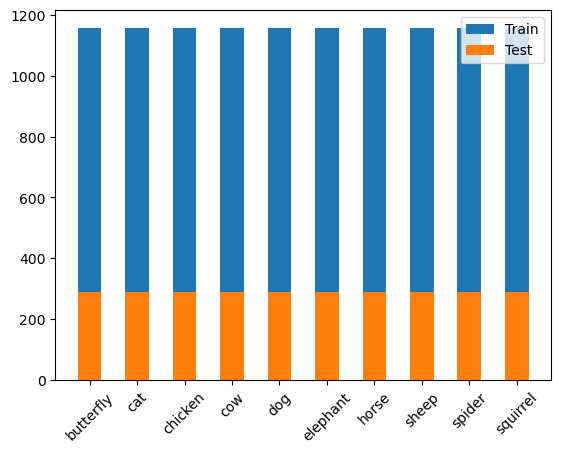

In [10]:
# Check train set and test set are correctly balanced, with same number of images per category
p1 = c.getTrain(maximums)["Label"].value_counts()
p2 = c.getTest(maximums)["Label"].value_counts()
# show as one plot with 2 bars per category, on top of each other
fig, ax = plt.subplots()
ax.bar(p1.index, p1.values, width=0.5, label="Train")
ax.bar(p2.index, p2.values, width=0.5, label="Test")

# Rotate x-axis labels by 45 degrees
ax.set_xticks(range(len(p1.index)))
ax.set_xticklabels(p1.index, rotation=45)

ax.legend()
plt.show()

In [11]:
df_train = c.getTrain(maximums).sample(frac=1).reset_index(drop=True) 
df_test = c.getTest(maximums).sample(frac=1).reset_index(drop=True)

In [12]:
from keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(validation_split=0.2,
                                   rescale = 1./255,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   horizontal_flip=True,
                                   rotation_range=10,
                                   zoom_range=0.2,
                                   brightness_range=(0.5, 1.3))
datagen_test = ImageDataGenerator(rescale=1./255)

In [13]:
set_train = datagen_train.flow_from_dataframe(
    dataframe=df_train,
    x_col="Filepath",
    y_col="Label",
    target_size=(WIDTH, HEIGHT),
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    subset="training"
)

set_validation = datagen_train.flow_from_dataframe(
    dataframe=df_train,
    x_col="Filepath",
    y_col="Label",
    target_size=(WIDTH, HEIGHT),
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    subset="validation"
)

set_test = datagen_test.flow_from_dataframe(
    dataframe=df_test,
    x_col="Filepath",
    y_col="Label",
    target_size=(WIDTH, HEIGHT),
    batch_size=1,
    shuffle=False,
    class_mode="categorical"
)

Found 9256 validated image filenames belonging to 10 classes.
Found 2314 validated image filenames belonging to 10 classes.


Found 2890 validated image filenames belonging to 10 classes.


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 256)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 99, 99, 256)      1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 99, 99, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 128)      0

In [15]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
if do("TRAIN"):
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint("e{epoch:02d}-a{val_accuracy:.3f}.keras", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"),
        tf.keras.callbacks.ModelCheckpoint("best.keras", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"),
        tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_images=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
    ]
    set_test.reset()
    model.fit(set_train,
                steps_per_epoch = len(set_train),
                validation_data = set_validation,
                validation_steps = len(set_validation),
                epochs=30,
                callbacks=callbacks,
                batch_size=32)


Epoch 1/30


2024-02-02 10:29:53.706905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-02 10:29:54.164393: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-02-02 10:29:56.996099: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a48f8dd50e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-02 10:29:56.996128: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-02 10:29:57.002897: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706866197.073636   18523 device_compiler.h:186] Compiled clust

290/290 [==============================] - ETA: 0s - loss: 2.1546 - accuracy: 0.2188
Epoch 1: val_accuracy improved from -inf to 0.11625, saving model to e01-a0.116.keras

Epoch 1: val_accuracy improved from -inf to 0.11625, saving model to best.keras
290/290 [==============================] - 117s 355ms/step - loss: 2.1546 - accuracy: 0.2188 - val_loss: 2.9384 - val_accuracy: 0.1162
Epoch 2/30
290/290 [==============================] - ETA: 0s - loss: 1.8354 - accuracy: 0.3439
Epoch 2: val_accuracy improved from 0.11625 to 0.18366, saving model to e02-a0.184.keras

Epoch 2: val_accuracy improved from 0.11625 to 0.18366, saving model to best.keras
290/290 [==============================] - 98s 338ms/step - loss: 1.8354 - accuracy: 0.3439 - val_loss: 2.7844 - val_accuracy: 0.1837
Epoch 3/30
290/290 [==============================] - ETA: 0s - loss: 1.6901 - accuracy: 0.4067
Epoch 3: val_accuracy improved from 0.18366 to 0.25022, saving model to e03-a0.250.keras

Epoch 3: val_accuracy im

In [26]:
model.load_weights("best.keras")
test_loss, test_acc = model.evaluate(set_test)
print('Test accuracy:', test_acc)
print('Test loss:',test_loss)

2890/2890 [==============================] - 10s 3ms/step - loss: 1.0793 - accuracy: 0.6709
Test accuracy: 0.67093425989151
Test loss: 1.0793302059173584


In [18]:
if do("SAVE_UNIVERSAL"):
    m = tf.keras.models.load_model("best.keras")
    m.export("model")

In [19]:
if do("ZIP"):
  import os
  with zipfile.ZipFile('model_and_logs.zip', 'w') as z:
      for root, dirs, files in os.walk('logs/'):
        for file in files:
          z.write(os.path.join(root, file),
                  os.path.relpath(os.path.join(root, file),
                  os.path.join('logs/', '..')))

      # Ajout du fichier "best.keras" à l'archive
      z.write("best.keras", os.path.basename("best.keras"))


In [20]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
def predict(model, imgFromSet):
  pred = model.predict(imgFromSet, verbose=0)
  return CATEGORIES[np.argmax(pred)]


On this sample : 34/50 (68.0%)


<Figure size 1000x500 with 0 Axes>

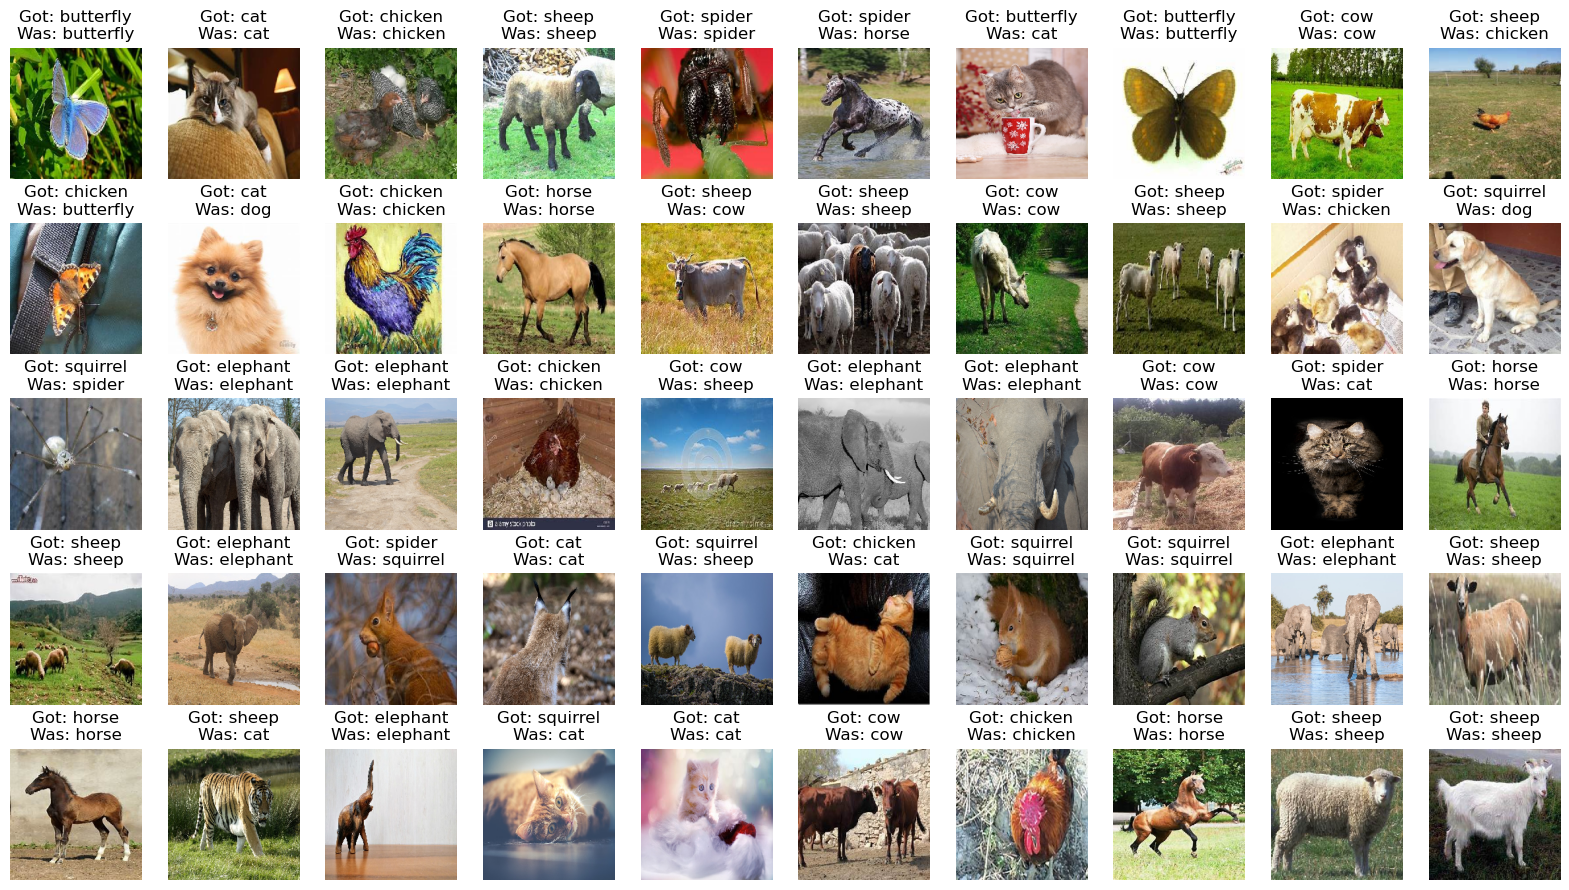

In [21]:
plt.figure(figsize=(10, 5))
set_test.reset()
right = 0
MAX = 50
width = min(MAX, 10)
height = (MAX + width - 1) // width
plt.subplots(height, width, figsize=(width * 2, height * 2+1))
for i in range(MAX):
  img, label = set_test.next()
  plt.subplot(height, width, i+1)
  plt.imshow(img[0])
  got = predict(model, img)
  was = CATEGORIES[np.argmax(label[0])]
  plt.title("Got: " + got + "\nWas: " + was)
  plt.axis('off')
  right += got == was
print(f"On this sample : {right}/{MAX} ({str(100*right/MAX)}%)")
plt.show()

In [22]:
confusion_matrix = np.zeros((10,10), dtype = int)

for i in range(len(set_test)):
  img, label = set_test.next()
  got = predict(model, img)
  was = CATEGORIES[np.argmax(label[0])]
  confusion_matrix[CATEGORIES.index(was)][CATEGORIES.index(got)] += 1


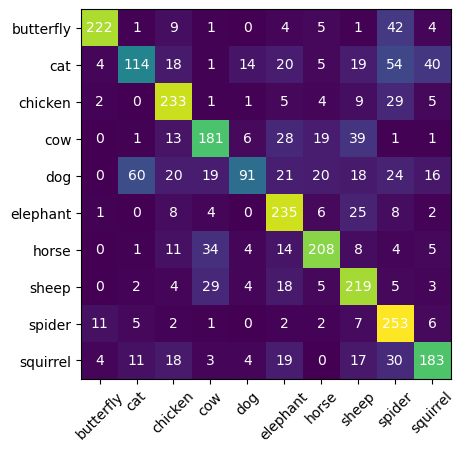

In [23]:
fig, ax = plt.subplots()

im = ax.imshow(confusion_matrix)

# Add numbers to each square
for i in range(len(CATEGORIES)):
    for j in range(len(CATEGORIES)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="w")
# axis labels as categories name

plt.xticks(range(len(CATEGORIES)), CATEGORIES, rotation=45)
plt.yticks(range(len(CATEGORIES)), CATEGORIES)
plt.show()


In [24]:
# Correctness rate from confusion matrix
m = max(CATEGORIES, key=len)
for i, c in enumerate(CATEGORIES):
    nbspace = " "*(len(m)-len(c))
    print(f"{c} {nbspace}: {confusion_matrix[i,i]/sum(confusion_matrix[i]):.2%}")

butterfly : 76.82%
cat       : 39.45%
chicken   : 80.62%
cow       : 62.63%
dog       : 31.49%
elephant  : 81.31%
horse     : 71.97%
sheep     : 75.78%
spider    : 87.54%
squirrel  : 63.32%


<Figure size 1000x500 with 0 Axes>

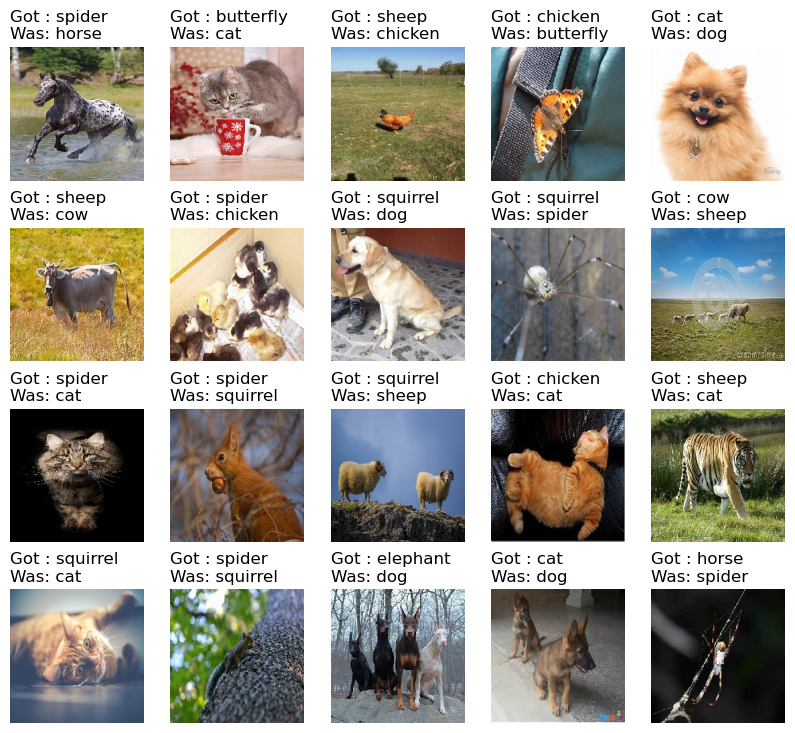

In [25]:
# Sample of uncorrectly classified images

plt.figure(figsize=(10, 5))
set_test.reset()
count = 0
MAX = 20
width = min(MAX, 5)
height = (MAX + width - 1) // width
plt.subplots(height, width, figsize=(width * 2, height * 2+1))
while count < MAX:
  img, label = set_test.next()
  got = predict(model, img)
  was = CATEGORIES[np.argmax(label[0])]
  if got != was:
    count += 1
    plt.subplot(height, width, count)
    plt.imshow(img[0])
    plt.title("Got : " + got + "\nWas: " + was, loc="left")
    plt.axis('off')